In [1]:
import pandas as pd 
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import os 
import re # for Regular Expressions
import string
import time
from numpy import random
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,InputLayer,BatchNormalization,
                                     Dropout,Input,LayerNormalization)
from tensorflow.keras.losses import (BinaryCrossentropy,CategoricalCrossentropy,
                                    SparseCategoricalCrossentropy)
from tensorflow.keras.metrics import (Accuracy,TopKCategoricalAccuracy,
                                 CategoricalAccuracy, SparseCategoricalAccuracy)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

C:\Users\Shaun\anaconda3\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
C:\Users\Shaun\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#New data with 200 more hate speech points with sentiment 
CLD= pd.read_csv('DataSentiment3class.csv')  
CLD= CLD.drop(columns='Unnamed: 0', axis=1)
CLD.head()

,class,tweet,Sentiment,Score
0,2,woman shouldnt complain cleaning house man alw...,Negative,0.566340
1,1,boy dat coldtyga dwn bad cuffin dat hoe 1st place,Negative,0.598608
2,1,dawg ever fuck bitch start cry confused shit,Negative,0.974858
3,1,look like tranny,Negative,0.673002
4,1,shit hear might true might faker bitch told ya,Negative,0.695477


## USing old data

In [2]:
SAD= pd.read_csv('ProcessedDataSentiment.csv')  'CombinedLabeledData.csv'
SAD= SAD.drop(columns='Unnamed: 0', axis=1)
SAD.head()

,class,tweet,Sentiment,Score
0,2,"['user', 'woman', 'shouldnt', 'complain', 'cle...",NEGATIVE,0.994189
1,1,"['user', 'boy', 'dat', 'coldtyga', 'dwn', 'bad...",NEGATIVE,0.998906
2,1,"['user', 'dawg', 'user', 'ever', 'fuck', 'bitc...",NEGATIVE,0.999260
3,1,"['user', 'user', 'look', 'like', 'tranny']",NEGATIVE,0.978730
4,1,"['user', 'shit', 'hear', 'might', 'true', 'mig...",NEGATIVE,0.996820


## SVM best parameters

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best Parameters: {'C': 1, 'class_weight': {0: 2, 1: 1, 2: 1}, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.9035106857214444
Accuracy: 0.8975186604801291
              precision    recall  f1-score   support

        Hate       0.45      0.36      0.40       290
   Offensive       0.94      0.94      0.94      3832
     Neither       0.84      0.87      0.86       835

    accuracy                           0.90      4957
   macro avg       0.74      0.73      0.73      4957
weighted avg       0.89      0.90      0.89      4957



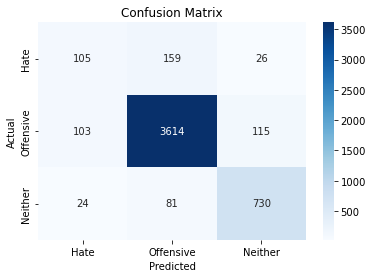

In [3]:
# Find SVM with best parameters
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import hstack

# Combine tokens into strings (if needed)
#SAD['tweet'] = SAD['tweet'].apply(lambda x: ' '.join(x))

# Convert Sentiment to numerical if it's not already
SAD['Sentiment'] = SAD['Sentiment'].apply(lambda x: 1 if x == 'NEGATIVE' else 0)

# Define the features and the label
X_text = SAD['tweet']
X_sentiment = SAD['Sentiment']
X_score = SAD['Score']
y = SAD['class']  # The target variable representing hate (0), offensive (1), neither (2)

# Train-test split
X_train_text, X_test_text, X_train_sentiment, X_test_sentiment, X_train_score, X_test_score, y_train, y_test = train_test_split(
    X_text, X_sentiment, X_score, y, test_size=0.2, random_state=42
)

# Vectorize the tweet text
vectorizer = TfidfVectorizer()  #max_features=10000
X_train_text_vec = vectorizer.fit_transform(X_train_text)
X_test_text_vec = vectorizer.transform(X_test_text)

# Combine all features: text, sentiment, score
X_train_combined = hstack([X_train_text_vec, X_train_sentiment.values.reshape(-1, 1), X_train_score.values.reshape(-1, 1)])
X_test_combined = hstack([X_test_text_vec, X_test_sentiment.values.reshape(-1, 1), X_test_score.values.reshape(-1, 1)])

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'degree': [2, 3, 4],  # Degree for polynomial kernel (ignored by other kernels)
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'class_weight': [{0: 3, 1: 1, 2: 1.25}, {0: 2, 1: 1, 2: 1}, 'balanced'],  # Class weights
}

# GridSearchCV for parameter tuning
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train_combined, y_train)

# Best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_}")

# Train the model with the best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train_combined, y_train)

# Predictions
y_pred = best_model.predict(X_test_combined)

# Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=['Hate', 'Offensive', 'Neither']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Hate', 'Offensive', 'Neither'], yticklabels=['Hate', 'Offensive', 'Neither'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [21]:
SAD.head(50)

,class,tweet,Sentiment,Score
0,2,"['user', 'woman', 'shouldnt', 'complain', 'cle...",1,0.994189
1,1,"['user', 'boy', 'dat', 'coldtyga', 'dwn', 'bad...",1,0.998906
2,1,"['user', 'dawg', 'user', 'ever', 'fuck', 'bitc...",1,0.999260
3,1,"['user', 'user', 'look', 'like', 'tranny']",1,0.978730
4,1,"['user', 'shit', 'hear', 'might', 'true', 'mig...",1,0.996820


## Extract 1000 data points for each class to balance data

In [30]:
# setting value of N as 2
N = 1000
 
# using groupby to group acc. to
# column 'Variable'
df1000 = SAD.groupby('class').head(N).reset_index(drop=True)
df1000['class'].value_counts()

2    1000
1    1000
0    1000
Name: class, dtype: int64

## BERT without sentiment analysis (3000 Tweets)

In [31]:
from transformers import BertTokenizer, BertModel, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from sklearn.model_selection import train_test_split
import pandas as pd

# Combine tokens into strings (if needed)
SAD['tweet'] = SAD['tweet'].apply(lambda x: ' '.join(x))

# Split into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df1000['tweet'], df1000['class'], test_size=0.2, random_state=42
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


C:\Users\Shaun\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)


In [33]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TweetDataset(train_encodings, train_labels.tolist())
test_dataset = TweetDataset(test_encodings, test_labels.tolist())


In [34]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # number of training epochs
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

trainer.train()


Step,Training Loss
10,1.118000
20,1.142500
30,1.120000
40,1.110200
50,1.092300
60,1.108900
70,1.113900
80,1.095300
90,1.082300
100,1.104000


TrainOutput(global_step=450, training_loss=0.9057711866166857, metrics={'train_runtime': 6869.6141, 'train_samples_per_second': 1.048, 'train_steps_per_second': 0.066, 'total_flos': 473604151910400.0, 'train_loss': 0.9057711866166857, 'epoch': 3.0})

In [35]:
outputs = trainer.predict(test_dataset)
predictions = np.argmax(outputs.predictions, axis=1)

# Specify the labels parameter to match your expected classes
labels = [0, 1, 2]  # 0: Hate, 1: Offensive, 2: Neither
target_names = ['Hate', 'Offensive', 'Neither']

# Evaluation
print(f"Accuracy: {accuracy_score(test_labels, predictions)}")
print(classification_report(test_labels, predictions, labels=labels, target_names=target_names))


Accuracy: 0.755
              precision    recall  f1-score   support

        Hate       0.70      0.60      0.65       181
   Offensive       0.78      0.81      0.80       223
     Neither       0.77      0.83      0.80       196

    accuracy                           0.76       600
   macro avg       0.75      0.75      0.75       600
weighted avg       0.75      0.76      0.75       600

